In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow as tf
from os import listdir

style.use('dark_background')


<h3> Load Data </h3>

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



In [2]:


#Load labels from csv
label = pd.read_csv('pokemon.csv')
label = label.sort_values(by = 'Name', ascending=True)
label2 = label.loc[(label.Type1 == 'Grass') | (label.Type1 == 'Water')]

grass_water_names = np.array(label2['Name'])
#Load all images from directory
pokemon_data = []
image_dir = 'images/images'
for name in grass_water_names:
    pokemon_sprite = image.imread(image_dir + '/' + name + '.png')
    pokemon_data.append(pokemon_sprite)
    
# convert list to numpy array  
pokemon_data = np.array(pokemon_data).astype(np.float32)

types = np.array(label2['Type1'])
# only using primary pokemon type
all_types = np.array(label['Type1'])


<h3> Encoding and Spliting Data </h3>

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



enc = LabelEncoder()
enc.fit(types)
types = enc.transform(types)


X_train, X_test, y_train, y_test = train_test_split(pokemon_data, types, test_size = 0.3, random_state = 4)



print(X_train.shape)
print(y_train.shape)

(134, 120, 120, 4)
(134,)


5 first training images


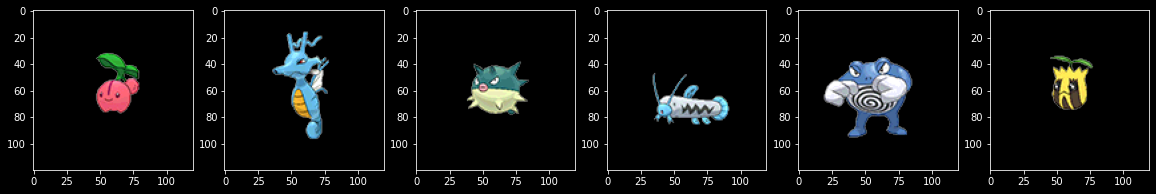

In [4]:
plt.figure(figsize=(20,3))
plt.subplot(1, 6, 1);
plt.imshow(X_train[0])

plt.subplot(1, 6, 2);
plt.imshow(X_train[1])

plt.subplot(1, 6, 3);
plt.imshow(X_train[2])

plt.subplot(1, 6, 4);
plt.imshow(X_train[3])

plt.subplot(1, 6, 5);
plt.imshow(X_train[4])

plt.subplot(1, 6, 6);

plt.imshow(X_train[5])
print("5 first training images")

<h3> Data Normalization and Augmentation </h3>

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#normalizing data
X_train /= 255.0
X_test /= 255.0

augmentation_layers = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomTranslation(0.2, 0.2)
])

<h3> Defining Model </h3>

In [9]:
#Custom CNN model
model = tf.keras.Sequential()
model.add(augmentation_layers)
model.add(layers.Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu', input_shape=(120, 120, 4) ))
model.add(layers.MaxPooling2D((2, 2), strides = (1, 1), padding = 'same'))
          
model.add(layers.Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2), strides = (1, 1), padding = 'same'))

model.add(layers.Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2), strides = (1, 1), padding = 'same'))
    
    
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))
    

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.build((None, 120, 120, 4))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 118, 118, 32)      1184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 58, 64)        12352     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 29, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 27, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 44928)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

<h3> Optimizing and Fitting Model </h3>

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

#early stop when validation accuracy drops
early_stop = EarlyStopping(min_delta = 0.001, patience = 30, restore_best_weights = True)

trained_model = model.fit(X_train, y_train,
                    batch_size = 32,
                    validation_data = (X_test, y_test),
                    shuffle = True,
                    callbacks = [early_stop],
                    epochs = 20
                   )

Epoch 1/20


InternalError:  Blas xGEMM launch failed : a.shape=[1,32,44928], b.shape=[1,44928,64], m=32, n=64, k=44928
	 [[node sequential_2/dense_2/MatMul (defined at <ipython-input-10-9996c3756d8f>:6) ]] [Op:__inference_train_function_1040]

Function call stack:
train_function


<h3> Validation and Prediction </h3>

In [ ]:
plt.plot(trained_model.history['accuracy'], label = 'accuracy')
plt.plot(trained_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])

loss, model_accuracy = model.evaluate(X_test, y_test)

print("Accuracy:", model_accuracy)